In [7]:
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from random import shuffle, choices
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    hamming_loss,
)

In [8]:
from GRU_pipeline import DataHolder, paths, MultiModalDicDataset, GRUModel, pad_collate
from models import GRUMultiModal

DH = DataHolder(**paths, none_as_class=True)

train_test_1 = DH.stratified_train_test_split(feature = 'multimodal', speaker = 1, none_count = 2000, test_size = .15, val_size = .17)
train_test_2 = DH.stratified_train_test_split(feature = 'multimodal', speaker = 2, none_count = 2000, test_size = .15, val_size = .17)

class_weights = train_test_1['class_weights']
class_weights = torch.Tensor([(1 - x) ** 5 for x in class_weights])

In [9]:
train_dataset_1 = MultiModalDicDataset(**train_test_1['data'])
test_dataset_1 = MultiModalDicDataset(train_dic_openface = train_test_1["data"]["test_dic_openface"], train_dic_opensmile = train_test_1["data"]["train_dic_opensmile"], features_openface = train_test_1["data"]["features_openface"], features_opensmile = train_test_1["data"]["features_opensmile"], embeds = train_test_1["data"]["embeds"], targets = train_test_1["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)
val_dataset_1 = MultiModalDicDataset(train_dic_openface = train_test_1["data"]["valid_dic_openface"], train_dic_opensmile = train_test_1["data"]["valid_dic_opensmile"], features_openface = train_test_1["data"]["features_openface"], features_opensmile = train_test_1["data"]["features_opensmile"], embeds = train_test_1["data"]["embeds"], targets = train_test_1["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)

train_loader_1 = DataLoader(train_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)
val_loader_1 = DataLoader(val_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)
test_loader_1 = DataLoader(test_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)

train_dataset_2 = MultiModalDicDataset(**train_test_2['data'])
test_dataset_2 = MultiModalDicDataset(train_dic_openface = train_test_2["data"]["test_dic_openface"], train_dic_opensmile = train_test_2["data"]["train_dic_opensmile"], features_openface = train_test_2["data"]["features_openface"], features_opensmile = train_test_2["data"]["features_opensmile"], embeds = train_test_2["data"]["embeds"], targets = train_test_2["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)
val_dataset_2 = MultiModalDicDataset(train_dic_openface = train_test_2["data"]["valid_dic_openface"], train_dic_opensmile = train_test_2["data"]["valid_dic_opensmile"], features_openface = train_test_2["data"]["features_openface"], features_opensmile = train_test_2["data"]["features_opensmile"], embeds = train_test_2["data"]["embeds"], targets = train_test_2["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)

train_loader_2 = DataLoader(train_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)
val_loader_2 = DataLoader(val_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)
test_loader_2 = DataLoader(test_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)

In [10]:
def eval_on_val():
    model.eval()
    tot_loss=0.0
    for i, batch in enumerate(val_loader_1):
        features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
        with torch.no_grad():
            pred = model(embeds, features_os, features_of)
            loss = criterion(pred, targets)
            tot_loss += loss / pred.shape[0]
    for i, batch in enumerate(val_loader_2):
        features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
        with torch.no_grad():
            pred = model(embeds, features_os, features_of)
            loss = criterion(pred, targets)
            tot_loss += loss / pred.shape[0]
    return (tot_loss / (len(val_loader_1) + len(val_loader_2)))

def train_one_epoch(epoch, dataloader_1, dataloader_2, hist_train_loss, hist_val_loss, stagnation):

    model.train(True)

    epoch_loss = 0.0
    best_vloss = 1000

    for i, batch in enumerate(dataloader_1):
        features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
        pred = model(embeds, features_os, features_of)
        loss = criterion(pred, targets)

        epoch_loss += loss / pred.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for i, batch in enumerate(dataloader_2):
        features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
        pred = model(embeds, features_os, features_of)
        loss = criterion(pred, targets)

        epoch_loss += loss / pred.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = epoch_loss / (len(dataloader_1) + len(dataloader_2))
    hist_train_loss = hist_train_loss + [epoch_loss]
    model.train(False)
    val_loss = eval_on_val()
    hist_val_loss = hist_val_loss + [val_loss]
    if epoch % 30 == 0:
        print("EPOCH {}:".format(epoch + 1))
        tqdm.write(f"================\nTraining epoch {epoch} :\nTrain loss = {1000 * epoch_loss}, Val loss = {1000 * val_loss}\n================")
    if val_loss < best_vloss:
        best_vloss = val_loss
        torch.save(model.state_dict(), "models/GRU_concat_test")
        stagnation = 0
    return hist_train_loss, hist_val_loss, stagnation

In [11]:
model = GRUMultiModal(embeddings_dim = 768, audio_input_dim=23, audio_hidden_dim=16, audio_hidden_dim2=8, audio_layer_dim=3, video_input_dim=17, video_hidden_dim=16, video_hidden_dim2=10, video_layer_dim=3, output_dim=6, dropout_prob=.1)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 5e-5)

EPOCHS = 500

hist_train_loss = []
hist_val_loss = []
device = torch.device("mps")
stagnation= 0

for epoch in tqdm(range(EPOCHS), total = EPOCHS):

    curr_train_loss, curr_val_loss = hist_train_loss, hist_val_loss
    if epoch % 30 == 0:
        print("EPOCH {}:".format(epoch + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    hist_train_loss, hist_val_loss, stagnation = train_one_epoch(
        epoch, train_loader_1, train_loader_2, hist_train_loss, hist_val_loss, stagnation
    )
    stagnation += 1

    if stagnation > 10:
        break
hist_train_loss = [x.detach().numpy() for x in hist_train_loss]
hist_val_loss = [x.detach().numpy() for x in hist_val_loss]

  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 1:


  0%|          | 1/500 [00:03<26:11,  3.15s/it]

EPOCH 1:
Training epoch 0 :
Train loss = 3.409080743789673, Val loss = 3.310105323791504


  6%|▌         | 30/500 [01:39<22:33,  2.88s/it]

EPOCH 31:


  6%|▌         | 31/500 [01:42<22:24,  2.87s/it]

EPOCH 31:
Training epoch 30 :
Train loss = 0.7525624632835388, Val loss = 0.8820804357528687


 12%|█▏        | 60/500 [03:13<23:19,  3.18s/it]

EPOCH 61:


 12%|█▏        | 61/500 [03:16<23:08,  3.16s/it]

EPOCH 61:
Training epoch 60 :
Train loss = 0.36485201120376587, Val loss = 0.42287689447402954


 18%|█▊        | 90/500 [05:08<25:48,  3.78s/it]

EPOCH 91:


 18%|█▊        | 91/500 [05:11<24:14,  3.56s/it]

EPOCH 91:
Training epoch 90 :
Train loss = 0.2263295203447342, Val loss = 0.27868571877479553


 24%|██▍       | 120/500 [06:43<21:10,  3.34s/it]

EPOCH 121:


 24%|██▍       | 121/500 [06:47<22:21,  3.54s/it]

EPOCH 121:
Training epoch 120 :
Train loss = 0.17663271725177765, Val loss = 0.24694931507110596


 30%|███       | 150/500 [08:16<18:03,  3.09s/it]

EPOCH 151:


 30%|███       | 151/500 [08:19<17:33,  3.02s/it]

EPOCH 151:
Training epoch 150 :
Train loss = 0.1526673436164856, Val loss = 0.23842231929302216


 36%|███▌      | 180/500 [09:45<16:26,  3.08s/it]

EPOCH 181:


 36%|███▌      | 181/500 [09:47<15:51,  2.98s/it]

EPOCH 181:
Training epoch 180 :
Train loss = 0.12844952940940857, Val loss = 0.2308255136013031


 42%|████▏     | 210/500 [11:23<16:08,  3.34s/it]

EPOCH 211:


 42%|████▏     | 211/500 [11:26<16:03,  3.33s/it]

EPOCH 211:
Training epoch 210 :
Train loss = 0.10881227254867554, Val loss = 0.22297070920467377


 48%|████▊     | 240/500 [13:04<14:40,  3.39s/it]

EPOCH 241:


 48%|████▊     | 241/500 [13:08<14:36,  3.38s/it]

EPOCH 241:
Training epoch 240 :
Train loss = 0.09300407022237778, Val loss = 0.24350523948669434


 54%|█████▍    | 270/500 [14:49<13:52,  3.62s/it]

EPOCH 271:


 54%|█████▍    | 271/500 [14:53<13:46,  3.61s/it]

EPOCH 271:
Training epoch 270 :
Train loss = 0.08898086100816727, Val loss = 0.2275647670030594


 60%|██████    | 300/500 [16:38<11:05,  3.33s/it]

EPOCH 301:


 60%|██████    | 301/500 [16:42<11:01,  3.32s/it]

EPOCH 301:
Training epoch 300 :
Train loss = 0.07109756022691727, Val loss = 0.25980663299560547


 66%|██████▌   | 330/500 [18:21<09:25,  3.33s/it]

EPOCH 331:


 66%|██████▌   | 331/500 [18:25<09:38,  3.42s/it]

EPOCH 331:
Training epoch 330 :
Train loss = 0.053657639771699905, Val loss = 0.2472703605890274


 72%|███████▏  | 360/500 [20:06<07:48,  3.35s/it]

EPOCH 361:


 72%|███████▏  | 361/500 [20:09<07:45,  3.35s/it]

EPOCH 361:
Training epoch 360 :
Train loss = 0.04327119141817093, Val loss = 0.25133538246154785


 78%|███████▊  | 390/500 [21:47<06:33,  3.58s/it]

EPOCH 391:


 78%|███████▊  | 391/500 [21:51<06:24,  3.52s/it]

EPOCH 391:
Training epoch 390 :
Train loss = 0.036746829748153687, Val loss = 0.2575993835926056


 84%|████████▍ | 420/500 [23:27<04:35,  3.44s/it]

EPOCH 421:


 84%|████████▍ | 421/500 [23:31<04:30,  3.42s/it]

EPOCH 421:
Training epoch 420 :
Train loss = 0.026929564774036407, Val loss = 0.2654242515563965


 90%|█████████ | 450/500 [25:10<02:52,  3.44s/it]

EPOCH 451:


 90%|█████████ | 451/500 [25:13<02:46,  3.40s/it]

EPOCH 451:
Training epoch 450 :
Train loss = 0.021353891119360924, Val loss = 0.2858463525772095


 96%|█████████▌| 480/500 [26:55<01:11,  3.57s/it]

EPOCH 481:


 96%|█████████▌| 481/500 [26:58<01:07,  3.55s/it]

EPOCH 481:
Training epoch 480 :
Train loss = 0.015525945462286472, Val loss = 0.3165803551673889


100%|██████████| 500/500 [28:13<00:00,  3.39s/it]


# Evaluation of the model

2it [00:00, 45.83it/s]
2it [00:00, 34.26it/s]
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start

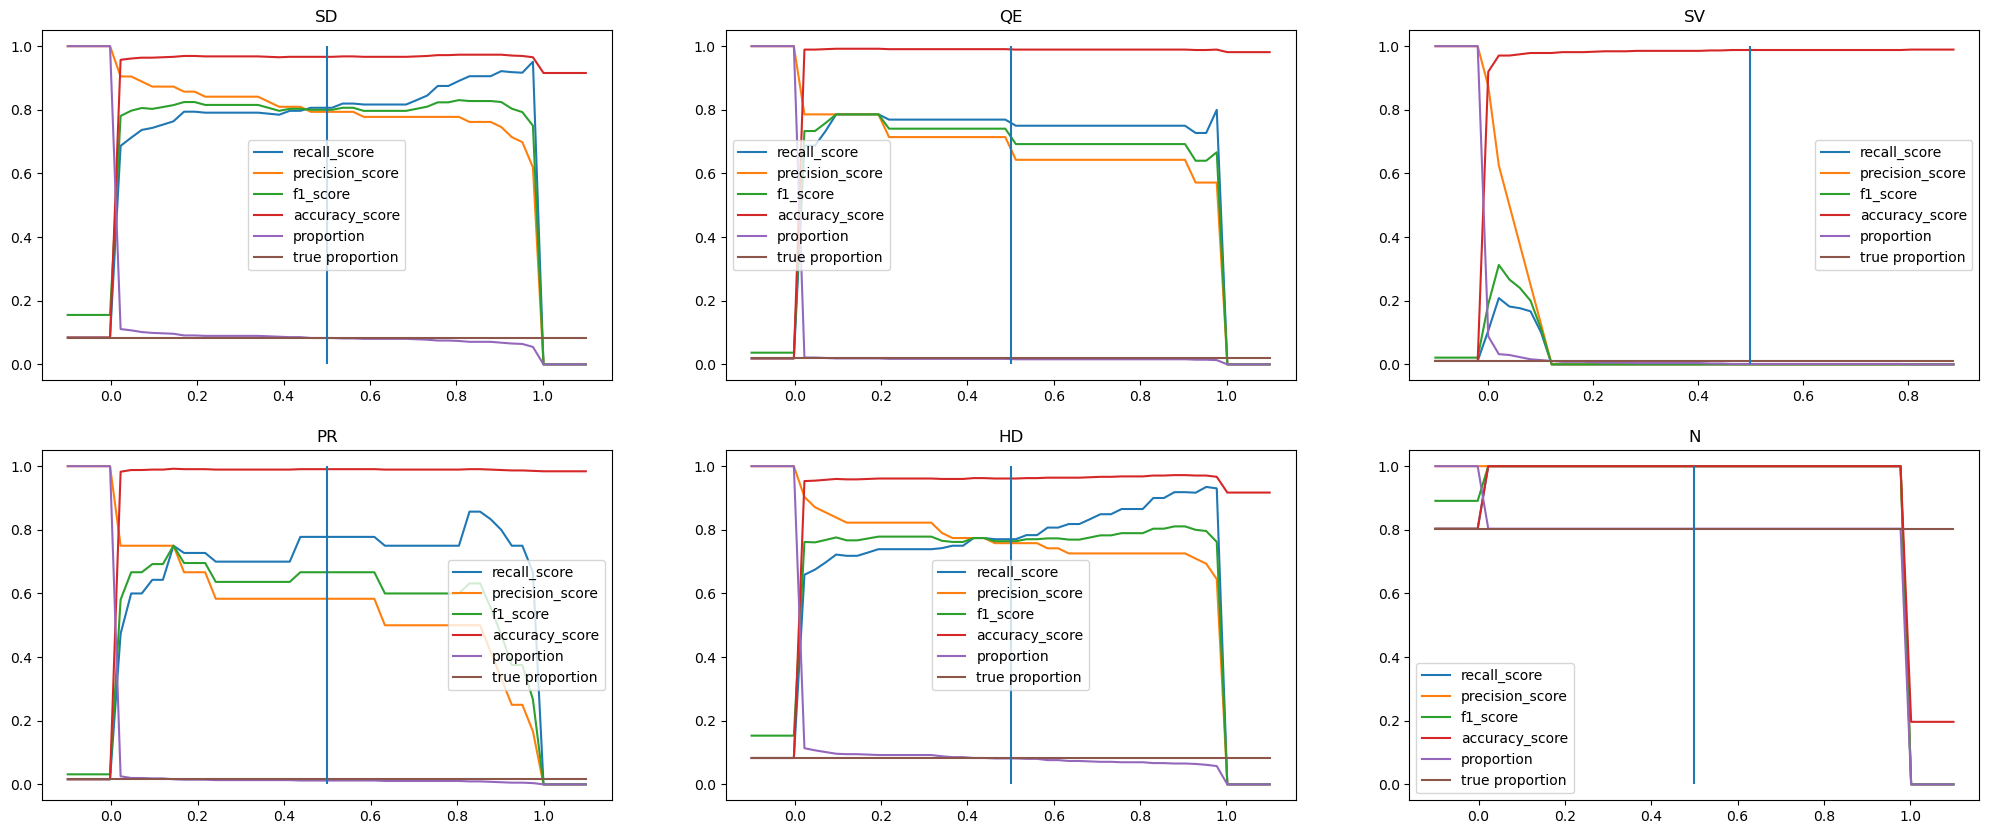

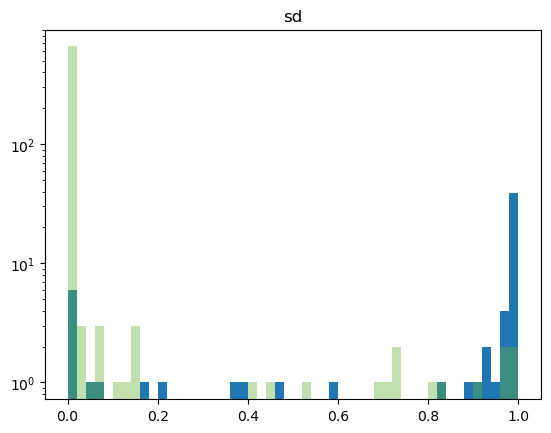

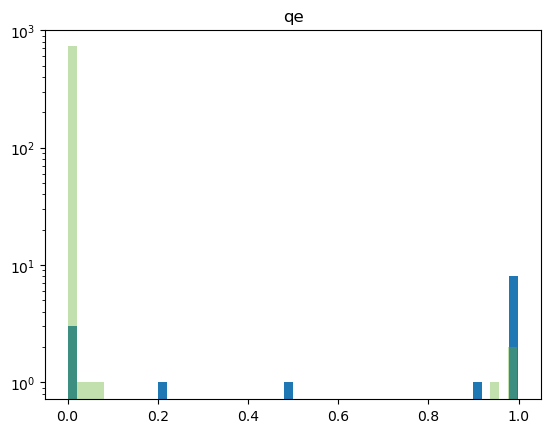

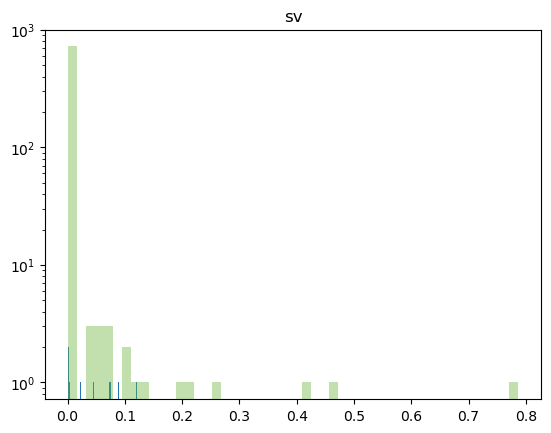

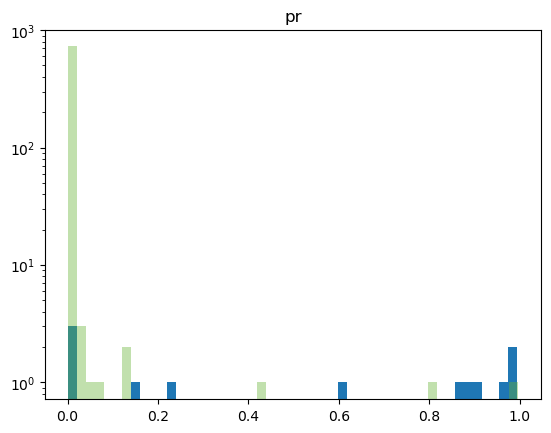

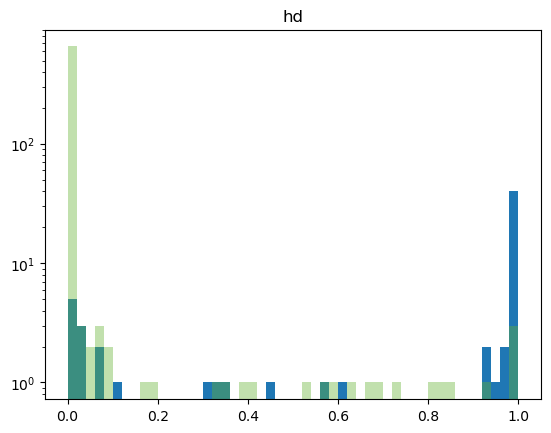

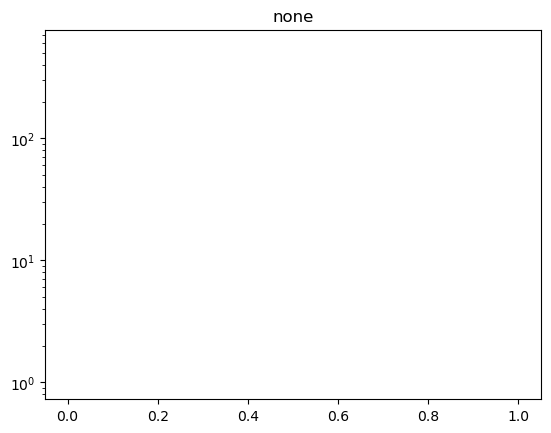

In [12]:
model = GRUMultiModal(embeddings_dim = 768, audio_input_dim=23, audio_hidden_dim=16, audio_hidden_dim2=8, audio_layer_dim=3, video_input_dim=17, video_hidden_dim=16, video_hidden_dim2=10, video_layer_dim=3, output_dim=6, dropout_prob=.1)
model.load_state_dict(torch.load("models/GRU_concat_test"))

fin_targets = []
fin_outputs = []

with torch.no_grad():
    for j, batch in tqdm(enumerate(test_loader_1)):
        features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
        pred = model(embeds, features_os, features_of)
        fin_targets.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs.extend(np.array(pred.cpu().detach().numpy()).tolist())

    for j, batch in tqdm(enumerate(test_loader_2)):
        features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
        pred = model(embeds, features_os, features_of)
        fin_targets.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs.extend(np.array(pred.cpu().detach().numpy()).tolist())

y_true = np.asarray(fin_targets)
pred_n = np.asarray(fin_outputs)

def explore_tresh(true, pred):
    tresh = np.linspace(pred.min()-.1,pred.max()+.1,50)
    out = [(
        precision_score(true, np.where(pred>t,1,0)),
        recall_score(true, np.where(pred>t,1,0)),
        f1_score(true, np.where(pred>t,1,0)),
        accuracy_score(true, np.where(pred>t, 1, 0)),
        np.where(pred>t,1,0).sum() / pred.shape[0],
        true.sum()/true.shape[0]
    ) for t in tresh]
    out = pd.DataFrame(out, columns=['recall_score', 'precision_score', 'f1_score', 'accuracy_score', 'proportion', 'true proportion'], index=tresh) #
    return out

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
df_pred = pd.DataFrame(pred_n, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
df_true = pd.DataFrame(y_true, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(6):
    explore_tresh(y_true[:,i], pred_n[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].vlines(0.5, 0, 1)
plt.savefig('BEAUTY_multimodal.jpg')
plt.figure()
plt.hist(df_pred.SD.loc[df_true.SD==1], bins = 50)
plt.hist(df_pred.SD.loc[df_true.SD==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("sd")
plt.yscale("log")
plt.show()
plt.hist(df_pred.QE.loc[df_true.QE==1], bins = 50,)
plt.hist(df_pred.QE.loc[df_true.QE==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("qe")
plt.yscale("log")
plt.show()
plt.hist(df_pred.SV.loc[df_true.SV==1], bins = 50,)
plt.hist(df_pred.SV.loc[df_true.SV==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("sv")
plt.yscale("log")
plt.show()
plt.hist(df_pred.PR.loc[df_true.PR==1], bins = 50,)
plt.hist(df_pred.PR.loc[df_true.PR==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("pr")
plt.yscale("log")
plt.show()
plt.hist(df_pred.HD.loc[df_true.HD==1], bins = 50,)
plt.hist(df_pred.HD.loc[df_true.HD==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("hd")
plt.yscale("log")
plt.show()
plt.hist(df_pred.N.loc[df_true.N==1], bins = 50,)
plt.hist(df_pred.N.loc[df_true.N==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("none")
plt.yscale("log")
plt.show()

# COMPARISON WITH TEXT ONLY

In [23]:
from transformers import BertModel, DistilBertTokenizer, DistilBertModel

class BertClassif(torch.nn.Module):
    """
    This model is a bi-modal classifier using a bilinear fusion layer for the two modalities.
    Text is embedded through pre-trained BERT, Action Units are embedded through two dense layers.
    """

    def __init__(self):
        super(BertClassif, self).__init__()

        # Define the Bert pipeline
        self.embeds_fc1 = torch.nn.Linear(768, 768)
        self.embeds_fc2 = torch.nn.Linear(768, 768 // 2)
        self.classifier = torch.nn.Linear(768 // 2, 6) # 6

        self.dropout = torch.nn.Dropout(0.25)
        self.class_num = 6
        self.ReLU = torch.nn.LeakyReLU(.1)
        self.sigmoid = torch.nn.Sigmoid()
        # Define the classifier

    def forward(self, embeddings):

        embeds_x = self.embeds_fc1(embeddings)
        embeds_x = self.ReLU(embeds_x)

        embeds_x = self.embeds_fc2(embeds_x)
        embeds_out = self.ReLU(embeds_x)

        out = self.classifier(embeds_out)
        out = self.sigmoid(out)
        return out

In [24]:
def eval_on_val_text():
    txt_model.eval()
    tot_loss=0.0
    for i, batch in enumerate(val_loader_1):
        embeds, targets = batch['embeds'], batch['targets']
        with torch.no_grad():
            pred = txt_model(embeds)
            loss = criterion(pred, targets)
            tot_loss += loss / pred.shape[0]
    for i, batch in enumerate(val_loader_2):
        embeds, targets = batch['embeds'], batch['targets']
        with torch.no_grad():
            pred = txt_model(embeds)
            loss = criterion(pred, targets)
            tot_loss += loss / pred.shape[0]
    return (tot_loss / (len(val_loader_1) + len(val_loader_2)))

def train_one_epoch_text(epoch, dataloader_1, dataloader_2, hist_train_loss, hist_val_loss, stagnation):

    txt_model.train(True)

    epoch_loss = 0.0
    best_vloss = 1000

    for i, batch in enumerate(dataloader_1):
        embeds, targets = batch['embeds'], batch['targets']
        pred = txt_model(embeds)
        loss = criterion(pred, targets)

        epoch_loss += loss / pred.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for i, batch in enumerate(dataloader_2):
        embeds, targets = batch['embeds'], batch['targets']
        pred = txt_model(embeds)
        loss = criterion(pred, targets)

        epoch_loss += loss / pred.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = epoch_loss / (len(dataloader_1) + len(dataloader_2))
    hist_train_loss = hist_train_loss + [epoch_loss]
    txt_model.train(False)
    val_loss = eval_on_val_text()
    hist_val_loss = hist_val_loss + [val_loss]
    if epoch % 30 == 0:
        print("EPOCH {}:".format(epoch + 1))
        tqdm.write(f"================\nTraining epoch {epoch} :\nTrain loss = {1000 * epoch_loss:.4f}, Val loss = {1000 * val_loss:.4f}\n================")
    if val_loss < best_vloss:
        best_vloss = val_loss
        torch.save(txt_model.state_dict(), "models/Text_comparison_test")
        stagnation = 0
    return hist_train_loss, hist_val_loss, stagnation

In [25]:
txt_model = BertClassif()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params = txt_model.parameters(), lr = 5e-5)

EPOCHS = 500

hist_train_loss = []
hist_val_loss = []
device = torch.device("mps")
stagnation= 0

for epoch in tqdm(range(EPOCHS), total = EPOCHS):

    curr_train_loss, curr_val_loss = hist_train_loss, hist_val_loss
    if epoch % 20 == 0:
        print("EPOCH {}:".format(epoch + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    txt_model.train(True)
    hist_train_loss, hist_val_loss, stagnation = train_one_epoch_text(
        epoch, train_loader_1, train_loader_2, hist_train_loss, hist_val_loss, stagnation
    )
    stagnation += 1

    if stagnation > 10:
        break
hist_train_loss = [x.detach().numpy() for x in hist_train_loss]
hist_val_loss = [x.detach().numpy() for x in hist_val_loss]

  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 1:


  0%|          | 1/500 [00:00<06:09,  1.35it/s]

EPOCH 1:
Training epoch 0 :
Train loss = 3.3178, Val loss = 3.1490


  4%|▍         | 20/500 [00:08<04:14,  1.88it/s]

EPOCH 21:


  6%|▌         | 31/500 [00:12<03:12,  2.43it/s]

EPOCH 31:
Training epoch 30 :
Train loss = 0.7176, Val loss = 0.8280


  8%|▊         | 40/500 [00:16<02:55,  2.63it/s]

EPOCH 41:


 12%|█▏        | 60/500 [00:24<02:55,  2.51it/s]

EPOCH 61:


 12%|█▏        | 61/500 [00:25<02:51,  2.56it/s]

EPOCH 61:
Training epoch 60 :
Train loss = 0.3458, Val loss = 0.4311


 16%|█▌        | 80/500 [00:32<02:45,  2.54it/s]

EPOCH 81:


 18%|█▊        | 91/500 [00:36<02:47,  2.44it/s]

EPOCH 91:
Training epoch 90 :
Train loss = 0.2210, Val loss = 0.2836


 20%|██        | 100/500 [00:39<02:07,  3.13it/s]

EPOCH 101:


 24%|██▍       | 120/500 [00:50<03:57,  1.60it/s]

EPOCH 121:


 24%|██▍       | 121/500 [00:50<04:00,  1.58it/s]

EPOCH 121:
Training epoch 120 :
Train loss = 0.1658, Val loss = 0.2368


 28%|██▊       | 140/500 [00:58<02:23,  2.51it/s]

EPOCH 141:


 30%|███       | 151/500 [01:02<02:17,  2.54it/s]

EPOCH 151:
Training epoch 150 :
Train loss = 0.1479, Val loss = 0.2401


 32%|███▏      | 160/500 [01:06<02:13,  2.55it/s]

EPOCH 161:


 36%|███▌      | 180/500 [01:14<02:30,  2.13it/s]

EPOCH 181:


 36%|███▌      | 181/500 [01:15<02:44,  1.93it/s]

EPOCH 181:
Training epoch 180 :
Train loss = 0.1257, Val loss = 0.2441


 40%|████      | 200/500 [01:24<01:59,  2.51it/s]

EPOCH 201:


 42%|████▏     | 211/500 [01:28<01:56,  2.49it/s]

EPOCH 211:
Training epoch 210 :
Train loss = 0.1073, Val loss = 0.2345


 44%|████▍     | 220/500 [01:32<01:56,  2.40it/s]

EPOCH 221:


 48%|████▊     | 240/500 [01:40<01:42,  2.54it/s]

EPOCH 241:


 48%|████▊     | 241/500 [01:40<01:42,  2.52it/s]

EPOCH 241:
Training epoch 240 :
Train loss = 0.0982, Val loss = 0.2459


 52%|█████▏    | 260/500 [01:48<01:40,  2.39it/s]

EPOCH 261:


 54%|█████▍    | 271/500 [01:53<01:37,  2.35it/s]

EPOCH 271:
Training epoch 270 :
Train loss = 0.0847, Val loss = 0.2495


 56%|█████▌    | 280/500 [01:56<01:27,  2.51it/s]

EPOCH 281:


 60%|██████    | 300/500 [02:04<01:20,  2.49it/s]

EPOCH 301:


 60%|██████    | 301/500 [02:05<01:28,  2.24it/s]

EPOCH 301:
Training epoch 300 :
Train loss = 0.0732, Val loss = 0.2580


 64%|██████▍   | 320/500 [02:12<01:13,  2.46it/s]

EPOCH 321:


 66%|██████▌   | 331/500 [02:17<01:11,  2.37it/s]

EPOCH 331:
Training epoch 330 :
Train loss = 0.0700, Val loss = 0.2696


 68%|██████▊   | 340/500 [02:21<01:20,  2.00it/s]

EPOCH 341:


 72%|███████▏  | 360/500 [02:30<00:55,  2.51it/s]

EPOCH 361:


 72%|███████▏  | 361/500 [02:31<00:54,  2.57it/s]

EPOCH 361:
Training epoch 360 :
Train loss = 0.0495, Val loss = 0.2568


 76%|███████▌  | 380/500 [02:41<01:13,  1.64it/s]

EPOCH 381:


 78%|███████▊  | 391/500 [02:45<00:44,  2.45it/s]

EPOCH 391:
Training epoch 390 :
Train loss = 0.0463, Val loss = 0.2877


 80%|████████  | 400/500 [02:49<00:39,  2.55it/s]

EPOCH 401:


 84%|████████▍ | 420/500 [02:57<00:32,  2.49it/s]

EPOCH 421:


 84%|████████▍ | 421/500 [02:57<00:32,  2.46it/s]

EPOCH 421:
Training epoch 420 :
Train loss = 0.0322, Val loss = 0.3121


 88%|████████▊ | 440/500 [03:08<00:24,  2.42it/s]

EPOCH 441:


 90%|█████████ | 451/500 [03:14<00:21,  2.30it/s]

EPOCH 451:
Training epoch 450 :
Train loss = 0.0252, Val loss = 0.3292


 92%|█████████▏| 460/500 [03:18<00:22,  1.80it/s]

EPOCH 461:


 96%|█████████▌| 480/500 [03:27<00:07,  2.54it/s]

EPOCH 481:


 96%|█████████▌| 481/500 [03:27<00:07,  2.57it/s]

EPOCH 481:
Training epoch 480 :
Train loss = 0.0205, Val loss = 0.3529


100%|██████████| 500/500 [03:35<00:00,  2.32it/s]


2it [00:00, 48.30it/s]
2it [00:00, 50.95it/s]
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start

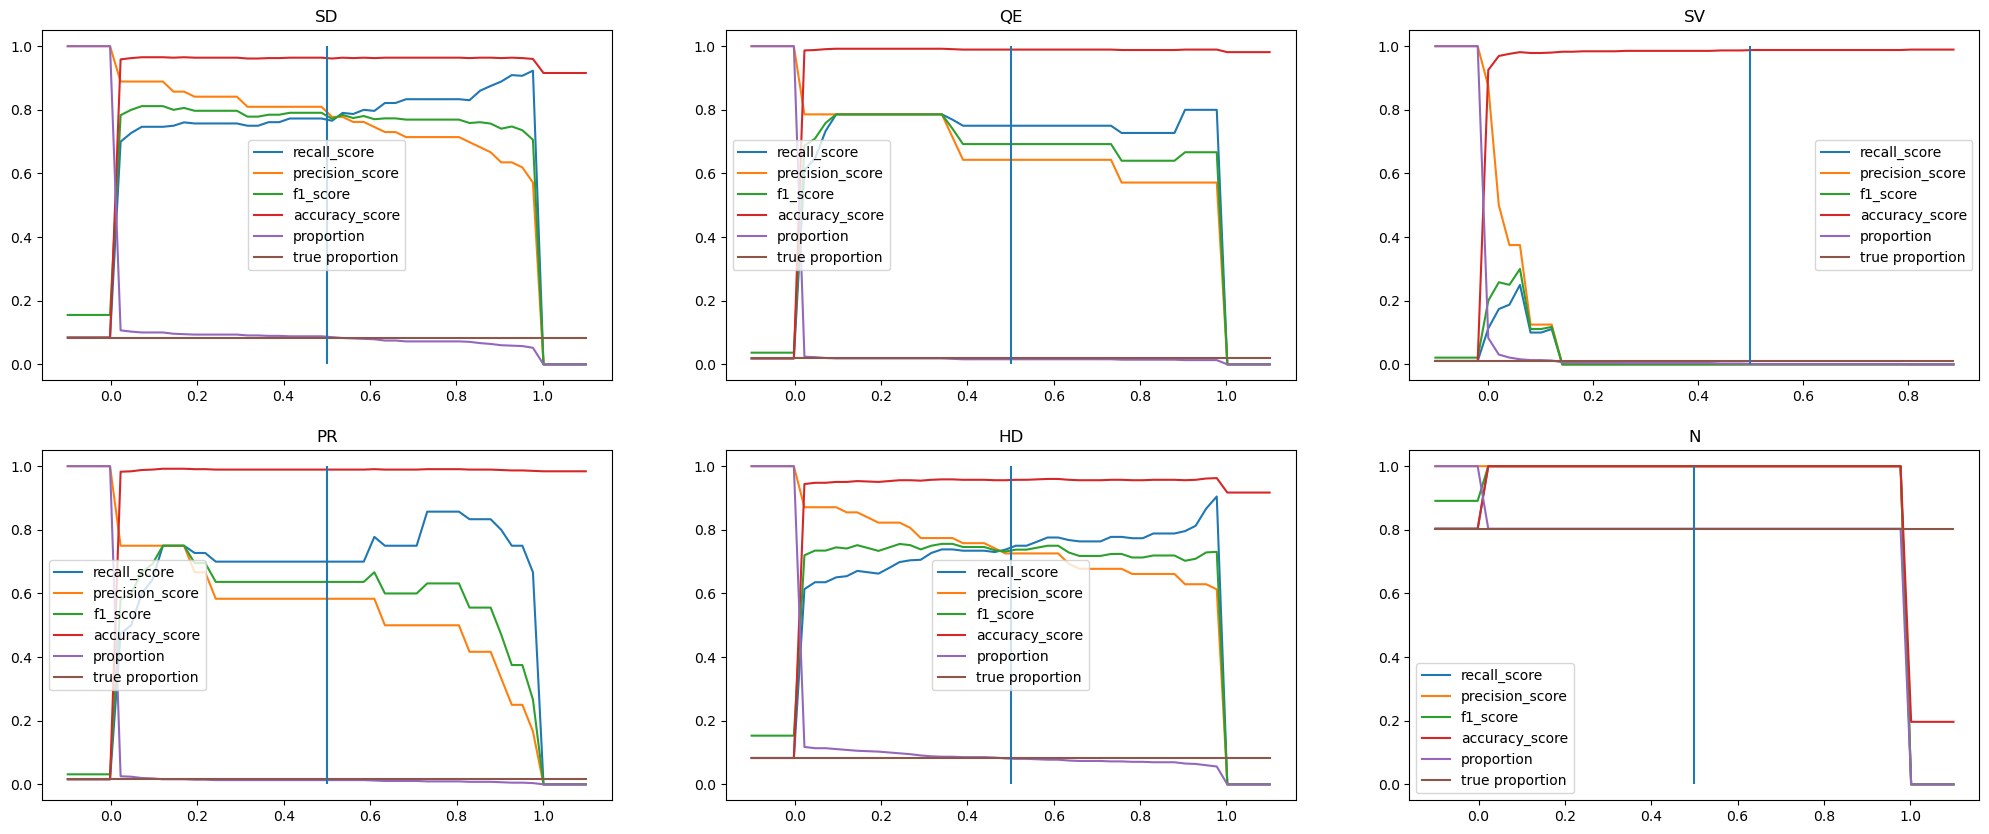

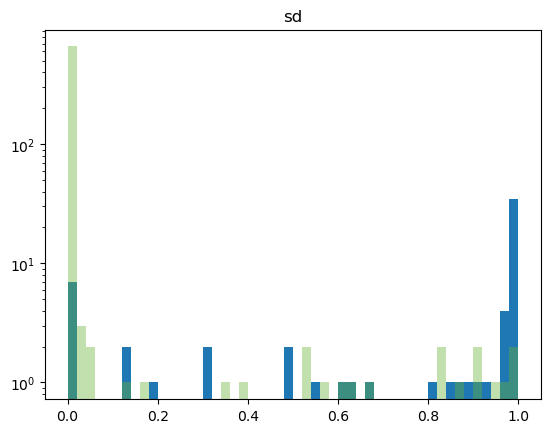

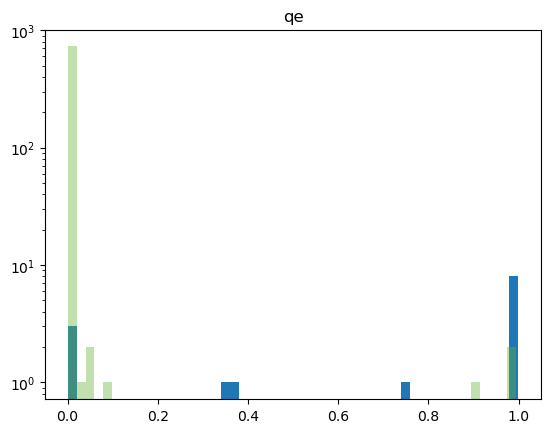

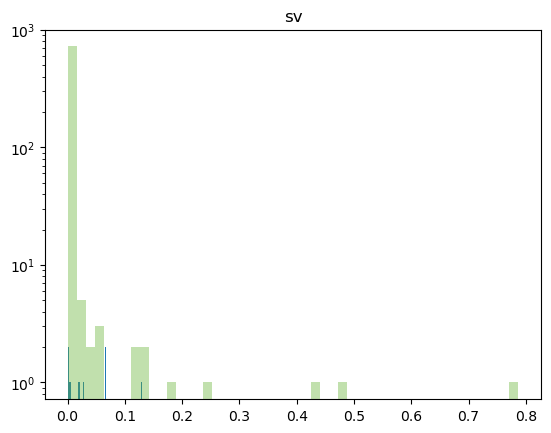

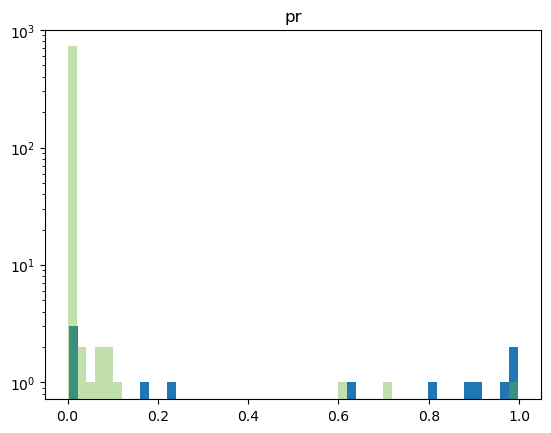

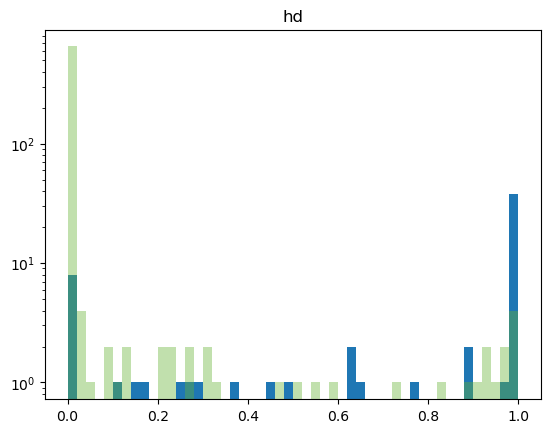

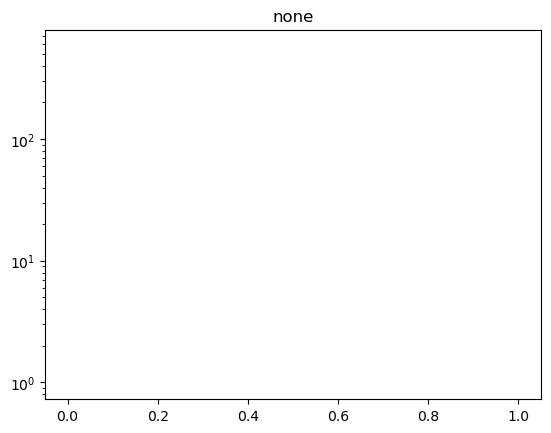

In [33]:
model_txt = BertClassif()
model_txt.load_state_dict(torch.load("models/Text_comparison_test"))

fin_targets_txt = []
fin_outputs_txt = []


with torch.no_grad():
    for j, batch in tqdm(enumerate(test_loader_1)):
        embeds, targets = batch['embeds'], batch['targets']
        pred = model_txt(embeds)
        fin_targets_txt.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs_txt.extend(np.array(pred.cpu().detach().numpy()).tolist())

    for j, batch in tqdm(enumerate(test_loader_2)):
        embeds, targets = batch['embeds'], batch['targets']
        pred = model_txt(embeds)
        fin_targets_txt.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs_txt.extend(np.array(pred.cpu().detach().numpy()).tolist())

y_true_txt = np.asarray(fin_targets_txt)
pred_n_txt = np.asarray(fin_outputs_txt)

def explore_tresh(true, pred):
    tresh = np.linspace(pred.min()-.1,pred.max()+.1,50)
    out_txt = [(
        precision_score(true, np.where(pred>t,1,0)),
        recall_score(true, np.where(pred>t,1,0)),
        f1_score(true, np.where(pred>t,1,0)),
        accuracy_score(true, np.where(pred>t, 1, 0)),
        np.where(pred>t,1,0).sum() / pred.shape[0],
        true.sum()/true.shape[0]
    ) for t in tresh]
    out_txt = pd.DataFrame(out_txt, columns=['recall_score', 'precision_score', 'f1_score', 'accuracy_score', 'proportion', 'true proportion'], index=tresh) #
    return out_txt

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
df_pred = pd.DataFrame(pred_n_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
df_true = pd.DataFrame(y_true_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(6):
    explore_tresh(y_true_txt[:,i], pred_n_txt[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].vlines(0.5, 0, 1)
plt.savefig('BEAUTY_text.jpg')
plt.figure()
plt.hist(df_pred.SD.loc[df_true.SD==1], bins = 50)
plt.hist(df_pred.SD.loc[df_true.SD==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("sd")
plt.yscale("log")
plt.show()
plt.hist(df_pred.QE.loc[df_true.QE==1], bins = 50,)
plt.hist(df_pred.QE.loc[df_true.QE==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("qe")
plt.yscale("log")
plt.show()
plt.hist(df_pred.SV.loc[df_true.SV==1], bins = 50,)
plt.hist(df_pred.SV.loc[df_true.SV==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("sv")
plt.yscale("log")
plt.show()
plt.hist(df_pred.PR.loc[df_true.PR==1], bins = 50,)
plt.hist(df_pred.PR.loc[df_true.PR==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("pr")
plt.yscale("log")
plt.show()
plt.hist(df_pred.HD.loc[df_true.HD==1], bins = 50,)
plt.hist(df_pred.HD.loc[df_true.HD==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("hd")
plt.yscale("log")
plt.show()
plt.hist(df_pred.N.loc[df_true.N==1], bins = 50,)
plt.hist(df_pred.N.loc[df_true.N==0], bins = 50, fc = (.4, .7, .2, .4))
plt.title("none")
plt.yscale("log")
plt.show()

# COMPARISON BETWEEN THE TWO MODELS

2it [00:00, 61.47it/s]
2it [00:00, 55.73it/s]
2it [00:00,  9.54it/s]
2it [00:00, 11.04it/s]
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this beha

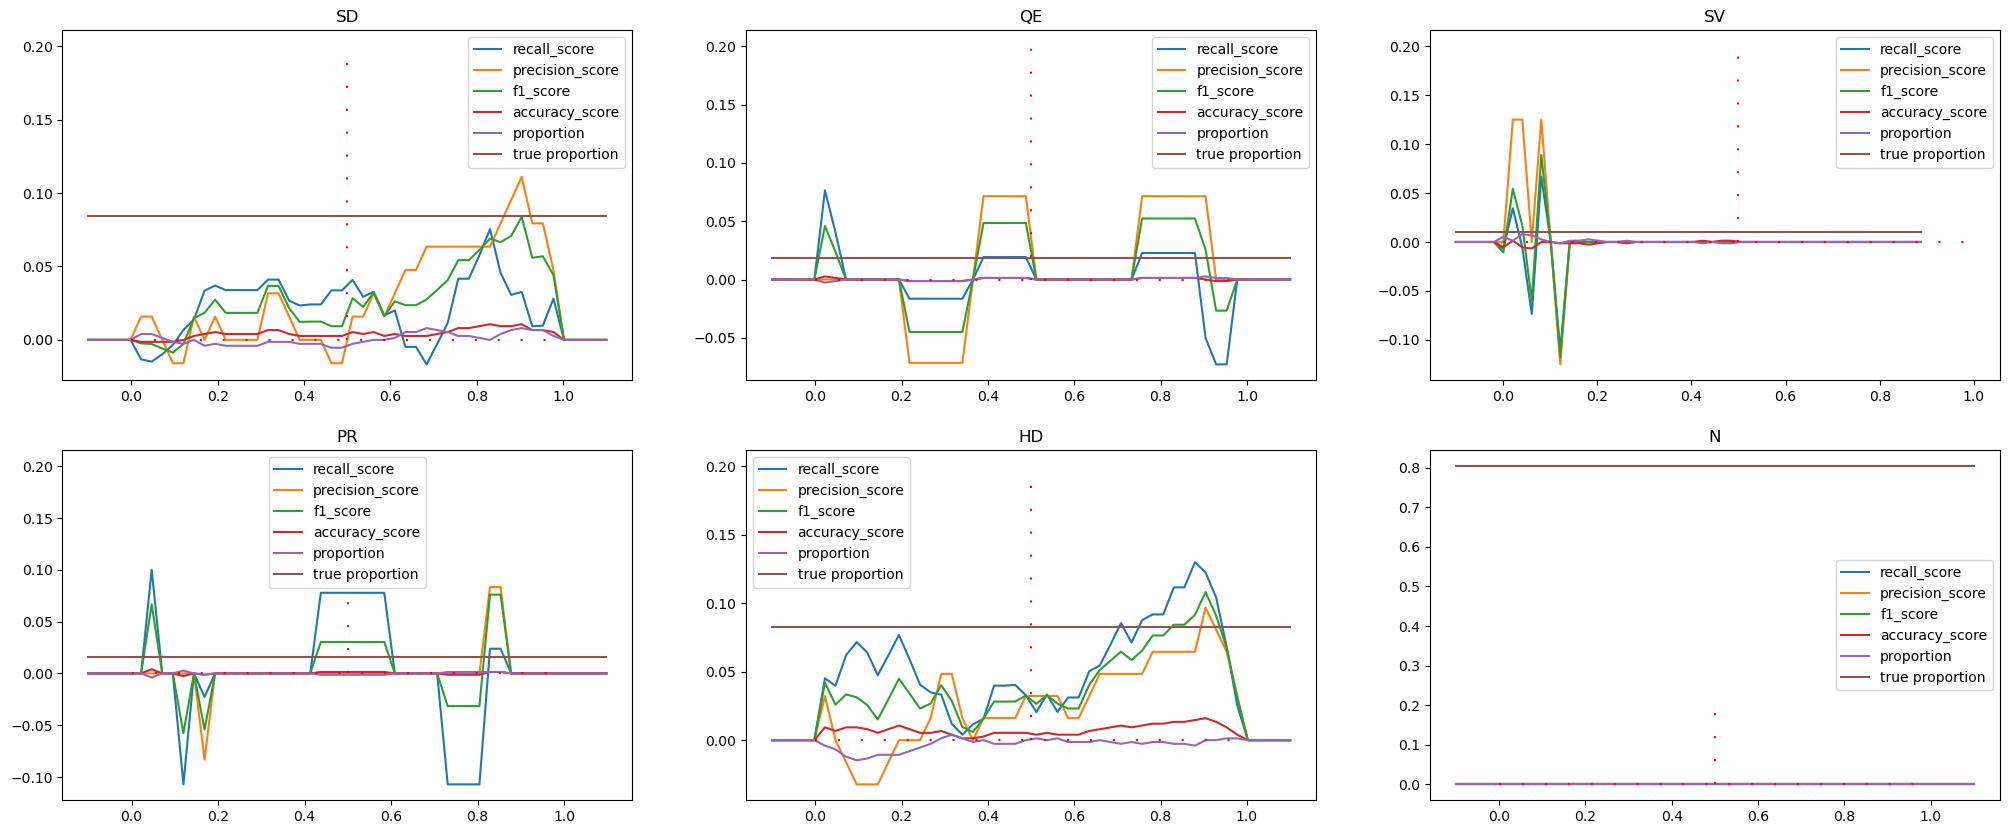

In [37]:
model_txt = BertClassif()
model_txt.load_state_dict(torch.load("models/Text_comparison_test"))

fin_targets_txt = []
fin_outputs_txt = []


def explore_tresh(true_txt, pred_txt, true, pred):
    tresh = np.linspace(pred.min()-.1,pred.max()+.1,50)
    out = [(
        np.subtract(precision_score(true, np.where(pred>t,1,0)), precision_score(true_txt, np.where(pred_txt>t,1,0))),
        np.subtract(recall_score(true, np.where(pred>t,1,0)), recall_score(true_txt, np.where(pred_txt>t,1,0))),
        np.subtract(f1_score(true, np.where(pred>t,1,0)), f1_score(true_txt, np.where(pred_txt>t,1,0))),
        np.subtract(accuracy_score(true, np.where(pred>t, 1, 0)), accuracy_score(true_txt, np.where(pred_txt>t, 1, 0))),
        np.subtract(np.where(pred>t,1,0).sum() / pred.shape[0], np.where(pred_txt>t,1,0).sum() / pred_txt.shape[0]),
        true.sum()/true.shape[0]
    ) for t in tresh]
    out = pd.DataFrame(out, columns=['recall_score', 'precision_score', 'f1_score', 'accuracy_score', 'proportion', 'true proportion'], index=tresh) #
    return out


with torch.no_grad():
    for j, batch in tqdm(enumerate(test_loader_1)):
        embeds, targets = batch['embeds'], batch['targets']
        pred = model_txt(embeds)
        fin_targets_txt.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs_txt.extend(np.array(pred.cpu().detach().numpy()).tolist())

    for j, batch in tqdm(enumerate(test_loader_2)):
        embeds, targets = batch['embeds'], batch['targets']
        pred = model_txt(embeds)
        fin_targets_txt.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs_txt.extend(np.array(pred.cpu().detach().numpy()).tolist())

y_true_txt = np.asarray(fin_targets_txt)
pred_n_txt = np.asarray(fin_outputs_txt)

model = GRUMultiModal(embeddings_dim = 768, audio_input_dim=23, audio_hidden_dim=16, audio_hidden_dim2=8, audio_layer_dim=3, video_input_dim=17, video_hidden_dim=16, video_hidden_dim2=10, video_layer_dim=3, output_dim=6, dropout_prob=.1)
model.load_state_dict(torch.load("models/GRU_concat_test"))

fin_targets = []
fin_outputs = []

with torch.no_grad():
    for j, batch in tqdm(enumerate(test_loader_1)):
        features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
        pred = model(embeds, features_os, features_of)
        fin_targets.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs.extend(np.array(pred.cpu().detach().numpy()).tolist())

    for j, batch in tqdm(enumerate(test_loader_2)):
        features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
        pred = model(embeds, features_os, features_of)
        fin_targets.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs.extend(np.array(pred.cpu().detach().numpy()).tolist())

y_true = np.asarray(fin_targets)
pred_n = np.asarray(fin_outputs)



fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
# df_pred = pd.DataFrame(pred_n_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
# df_true = pd.DataFrame(y_true_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(6):
    explore_tresh(y_true_txt[:,i], pred_n_txt[:,i], y_true[:,i], pred_n[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].hlines(0, 0, 1, color = "red", linestyle = (0, (1, 10)))
    axes[int(i/3), (i % 3)].vlines(0.5, 0, .2, color = "red", linestyle = (0, (1, 10)))

plt.savefig('Comparson_Multimodal_txt.jpg')
# plt.figure()
# plt.hist(df_pred.SD.loc[df_true.SD==1], bins = 50)
# plt.hist(df_pred.SD.loc[df_true.SD==0], bins = 50, fc = (.4, .7, .2, .4))
# plt.title("sd")
# plt.yscale("log")
# plt.show()
# plt.hist(df_pred.QE.loc[df_true.QE==1], bins = 50,)
# plt.hist(df_pred.QE.loc[df_true.QE==0], bins = 50, fc = (.4, .7, .2, .4))
# plt.title("qe")
# plt.yscale("log")
# plt.show()
# plt.hist(df_pred.SV.loc[df_true.SV==1], bins = 50,)
# plt.hist(df_pred.SV.loc[df_true.SV==0], bins = 50, fc = (.4, .7, .2, .4))
# plt.title("sv")
# plt.yscale("log")
# plt.show()
# plt.hist(df_pred.PR.loc[df_true.PR==1], bins = 50,)
# plt.hist(df_pred.PR.loc[df_true.PR==0], bins = 50, fc = (.4, .7, .2, .4))
# plt.title("pr")
# plt.yscale("log")
# plt.show()
# plt.hist(df_pred.HD.loc[df_true.HD==1], bins = 50,)
# plt.hist(df_pred.HD.loc[df_true.HD==0], bins = 50, fc = (.4, .7, .2, .4))
# plt.title("hd")
# plt.yscale("log")
# plt.show()
# plt.hist(df_pred.N.loc[df_true.N==1], bins = 50,)
# plt.hist(df_pred.N.loc[df_true.N==0], bins = 50, fc = (.4, .7, .2, .4))
# plt.title("none")
# plt.yscale("log")
# plt.show()